In [82]:
# Import necessary libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



## 1. Import Libraries

We import xarray to handle the .nc (NetCDF) files from Copernicus.

We import pandas and numpy for data manipulation, calculations (like mean, std dev), and all our math.

We import matplotlib to create our plots.

In [83]:
# Define file paths
rain_file = "rainfall_jj_india_1961_2020.nc"
sst_file = "sst_djf_pac_ind_1960_2020.nc"

#  Load Y (Rainfall Target) 
print(f"Loading rainfall data from: {rain_file}")
try:
    ds_rain = xr.open_dataset(rain_file)
    print("Rainfall data (ERA5) loaded.")
except Exception as e:
    print(f"*** ERROR loading rainfall file: {e} ***")
    

#  Load X (SST Predictors) 
print(f"\nLoading SST data from: {sst_file}")
try:
    ds_sst = xr.open_dataset(sst_file)
    print("SST data (ERA5) loaded.")
except Exception as e:
    print(f"*** ERROR loading SST file: {e} ***")
    

print("\n Raw SST Data Summary ")
print(ds_sst)

Loading rainfall data from: rainfall_jj_india_1961_2020.nc
Rainfall data (ERA5) loaded.

Loading SST data from: sst_djf_pac_ind_1960_2020.nc
SST data (ERA5) loaded.

 Raw SST Data Summary 
<xarray.Dataset> Size: 99MB
Dimensions:     (valid_time: 183, latitude: 241, longitude: 561)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 1kB 1960-01-01 ... 2020-12-01
  * latitude    (latitude) float64 2kB 30.0 29.75 29.5 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 4kB 40.0 40.25 40.5 ... 179.5 179.8 180.0
    expver      (valid_time) <U4 3kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 99MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-30T16:54 GRI

## 2. Load Data Files
   
We load the two NetCDF files we downloaded from Copernicus.

ds_rain will be used to create our Y variable (the rainfall we want to predict).

ds_sst will be used to create our X variables (the ocean temperatures that will be our predictors).

In [84]:
print("\n 3A: Preparing Y (Rainfall) ")

# FIX: Rename 'valid_time' to 'time' if it exists 
if 'valid_time' in ds_rain.coords:
    print("Found 'valid_time' in rainfall data, renaming to 'time'.")
    ds_rain = ds_rain.rename({'valid_time': 'time'})

# 1. Select the variable 'tp' (total precipitation)
rain_tp = ds_rain['tp']

# 2. Calculate the spatial average (mean over lat and lon) for each month
rain_india_monthly = rain_tp.mean(dim=['latitude', 'longitude'])
print("1. Calculated spatial average for rainfall.")

# 3. Resample by year ('A-SEP') and sum the months to get total seasonal rainfall
y_series = rain_india_monthly.resample(time='A-SEP').sum(dim='time')
print("2. Calculated annual (JJAS) rainfall total for each year.")

# 4. Convert from meters (ERA5 default) to millimeters
y_series = y_series * 1000
y_series.attrs['units'] = 'mm'

# 5. Convert to a pandas Series for easy handling
y_df = y_series.to_dataframe(name='Rainfall_JJAS')
y_df['Year'] = y_df.index.year
y_df = y_df.set_index('Year')

# Dropping the 'number' column, as it's not needed
if 'number' in y_df.columns:
    y_df = y_df.drop(columns=['number'])
print("3. Created final Y (Rainfall) time series.")


print("\n 3B: Preparing X (SST) ")

# --- FIX: Rename 'valid_time' to 'time' if it exists ---
if 'valid_time' in ds_sst.coords:
    print("Found 'valid_time' in SST data, renaming to 'time'.")
    ds_sst = ds_sst.rename({'valid_time': 'time'})

# 1. Select the variable 'sst' (sea surface temp)
sst = ds_sst['sst']

# 2. Resample by year ('A-FEB') and average the months to get mean seasonal SST
X_series = sst.resample(time='A-FEB').mean(dim='time')
print("1. Calculated annual (DJF) SST average for each year.")

# 3. Create a 'Year' coordinate that matches the rainfall data
X_series['Year'] = X_series.time.dt.year
X_series = X_series.set_index(time='Year')

# Drop the 'number' coordinate
if 'number' in X_series.coords:
    X_series = X_series.drop_vars('number')
print("2. Aligned SST 'Year' to match Rainfall 'Year'.")


print("\n--- 3C: Align Data & Handle NaNs ---")
# We need to make sure the Y (Rainfall) and X (SST) are on the same time index.
# We will use xr.align() to keep only the common years (1961-2020).
# We must convert y_df back to an xarray Dataset and X_series to a Dataset for this.

y_to_align = y_df.to_xarray()
X_to_align = X_series.to_dataset() # .to_dataset() converts the 'sst' DataArray

# xr.align is the correct way to merge on common coordinates
y_aligned, X_aligned = xr.align(y_to_align, X_to_align, join='inner')

print(f"1. Aligned Y (Rainfall) and X (SST) using 'inner' join.")

# Getting the final, aligned Y and X arrays as numpy arrays
y_np = y_aligned['Rainfall_JJAS'].values
X_np_3D = X_aligned['sst'].values

# 2. Handling NaNs in the X data (Land values)
X_np_3D_filled = np.nan_to_num(X_np_3D, nan=0.0)
print(f"2. Filled {np.isnan(X_np_3D).sum()} NaN values in X with 0.")


print("\n 3D: Flatten X Array ")
# 1. Get the shape: (time, lat, lon)
# We use 'X_np_3D_filled' here as it's the cleaned numpy array
n_time, n_lat, n_lon = X_np_3D_filled.shape

# 2. Reshape to 2D (time, features) where features = lat * lon
X_flat_np = X_np_3D_filled.reshape(n_time, n_lat * n_lon)

# 3. Save the 'time' index for later
final_years = y_aligned.Year.values

print(f"Final Y (rainfall) shape: {y_np.shape}")
print(f"Final X (SST) shape: {X_flat_np.shape} (Time, Space)")
print(f"Final Y (rainfall) n_time: {y_np.shape[0]}")
print(f"Final X_np_3D_filled n_time: {n_time}")
print(f"Years of data: {final_years.min()} to {final_years.max()}")


 3A: Preparing Y (Rainfall) 
Found 'valid_time' in rainfall data, renaming to 'time'.
1. Calculated spatial average for rainfall.
2. Calculated annual (JJAS) rainfall total for each year.
3. Created final Y (Rainfall) time series.

 3B: Preparing X (SST) 
Found 'valid_time' in SST data, renaming to 'time'.


C:\Users\VICTUS\anaconda3\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  self.index_grouper = pd.Grouper(
C:\Users\VICTUS\anaconda3\Lib\site-packages\xarray\groupers.py:530: FutureWarning: 'A-FEB' is deprecated and will be removed in a future version, please use 'YE-FEB' instead.
  self.index_grouper = pd.Grouper(


1. Calculated annual (DJF) SST average for each year.
2. Aligned SST 'Year' to match Rainfall 'Year'.

--- 3C: Align Data & Handle NaNs ---
1. Aligned Y (Rainfall) and X (SST) using 'inner' join.
2. Filled 1860620 NaN values in X with 0.

 3D: Flatten X Array 
Final Y (rainfall) shape: (60,)
Final X (SST) shape: (62, 135201) (Time, Space)
Final Y (rainfall) n_time: 60
Final X_np_3D_filled n_time: 62
Years of data: 1961 to 2020


## 3. Data Preparation

This is the most complex part. We need to create two matching time series from our raw grid files:

A. Preparing Y (Rainfall):

We select the tp (total precipitation) variable.

We use .mean(dim=['latitude', 'longitude']) to average the rainfall over the entire Indian map, giving us one value per month.

We use .resample(time='A-SEP').sum() to add up the monthly values (Jun+Jul+Aug+Sep) for each year. This gives us our final seasonal rainfall total for each year.

We convert this to a pandas DataFrame, using the 'Year' as the index.

B. Preparing X (SST):

We select the sst variable.

We use .resample(time='A-FEB').mean() to average the winter months (Dec, Jan, Feb) for each year.

The 'Year' for this (e.g., 1961) now correctly represents the 1960-1961 winter.

C. Combine Data:

We use xr.merge(..., join='inner') to combine the rainfall and SST data. join='inner' is important: it only keeps years that exist in both datasets, automatically aligning them.

We fill all the NaNs (land values) in the SST data with 0 using np.nan_to_num. This is a simple imputation step.

D. Flatten X Array:

We get the final Y and X data as NumPy arrays using .values.

We use np.reshape() to flatten the 3D X array (time, lat, lon) into a 2D array (time, features) that we can use for PCA.

 4. Exploratory Data Analysis (EDA) 
Calculating correlation map (Y vs. all X points)


C:\Users\VICTUS\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\VICTUS\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation map calculated.
Plotting correlation map


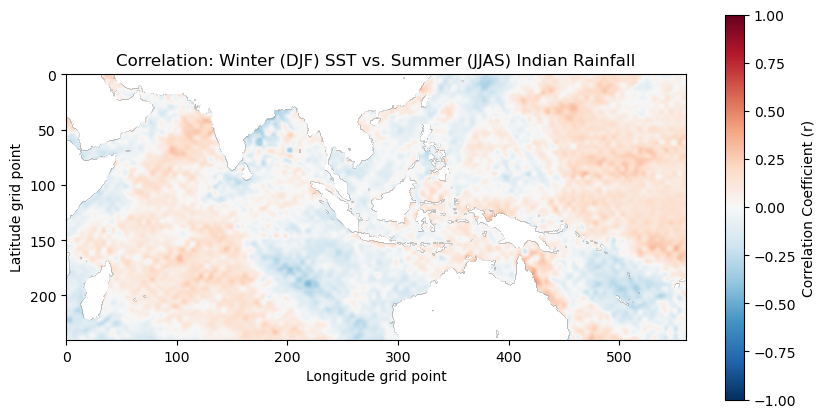


 EDA Finished 


In [85]:
# Before we build a model, we need to check at our data.
# We want to see if there is any obvious relationship between our Y (rainfall)
# and our X (SST map).
# Since X is huge (40,320 features), we can't plot it all.
# But, we can calculate the correlation between Y (rainfall) and *every single*
# grid point in our X (SST map).

print(" 4. Exploratory Data Analysis (EDA) ")

# We have Y (y_np) and the 3D X (X_np_3D_filled) from the previous step
# we will use the 3D X array so we can plot the correlations on a map.

# We will calculate the correlation of Y with each spatial point over time.
# Y shape is (time,)
# X_np_3D_filled shape is (time, lat, lon)

# Get the dimensions
n_time, n_lat, n_lon = X_np_3D_filled.shape

# Create an empty numpy array to store our correlation map
correlation_map = np.zeros((n_lat, n_lon))

print("Calculating correlation map (Y vs. all X points)")
# Loop over every lat and lon point
for i in range(n_lat):
    for j in range(n_lon):
        # Get the time series for this one grid point
        sst_point_series = X_np_3D_filled[0:60, i, j]
        
        # Calculate the correlation between this point's SST and the rainfall (Y)
        # np.corrcoef() returns a 2x2 matrix, we just want the [0, 1] value
        correlation = np.corrcoef(y_np, sst_point_series)[0, 1]
        
        # Save it to our map
        correlation_map[i, j] = correlation

print("Correlation map calculated.")

# Plot the correlation map
print("Plotting correlation map")
plt.figure(figsize=(10, 5))

# Using imshow() for a simple, basic 2D plot of our new map
# 'cmap='RdBu_r'' (Red-Blue) is good for correlations: Red=positive, Blue=negative
plt.imshow(correlation_map, cmap='RdBu_r', vmin=-1, vmax=1)

plt.colorbar(label='Correlation Coefficient (r)')
plt.title('Correlation: Winter (DJF) SST vs. Summer (JJAS) Indian Rainfall')
plt.xlabel('Longitude grid point')
plt.ylabel('Latitude grid point')
plt.show()

print("\n EDA Finished ")

## 4. Exploratory Data Analysis (EDA)
Before building a model, I wanted to "figure out the data" as discussed in my email. I wanted to see where in the ocean the winter SSTs have the strongest relationship with my Indian rainfall.

Since my X data is a 3D map (time, lat, lon), I can't make a simple scatter plot.

Instead, I wrote a double for loop to go through every single latitude and longitude point.

For each point, I extracted its SST time series and used np.corrcoef() to calculate the correlation between that single point's SST and my y (rainfall) time series.

I saved these correlation values into a new 2D array called correlation_map.

Finally, I plotted this correlation_map with plt.imshow(). The red areas show a positive correlation (warm winter = more rain), and blue areas show a negative correlation (warm winter = less rain). This helps me see regions like the El Niño area that are dominant.

In [86]:
# STEP 4.5: FEATURE SELECTION (with NaN fix)
# We will select the 100 features (grid points) that have the
# highest correlation with rainfall.

# 1. Flatten the 2D correlation map into a 1D array
flat_correlations = correlation_map.flatten()

# --- THIS IS THE FIX ---
# Replace any NaN values (from no-variance data) with 0
# so they don't get selected as "top" features.
flat_correlations = np.nan_to_num(flat_correlations, nan=0.0)
# --- END OF FIX ---

# 2. Get the 'absolute' value
abs_correlations = np.abs(flat_correlations)

# 3. Get the indices (positions) of the 100 largest values
# Let's go back to 100 features. This fix should be all we need.
num_features_to_select = 100
top_feature_indices = np.argsort(abs_correlations)[-num_features_to_select:]

print(f"Original number of features: {X_flat_np.shape[1]}")
print(f"New number of features selected: {len(top_feature_indices)}")

# 4. Create a new X array with *only* these top 100 features
X_flat_np_selected = X_flat_np[:, top_feature_indices]

Original number of features: 135201
New number of features selected: 100


In [87]:
# Now we split our 2D flattened data (X_flat_np and y_np)
# We will use the 'final_years' array we saved from Step 3

print("\n 5. Splitting Data for Model Training ")

# We will use data up to 2005 for training and data from 2006 onwards for testing.
split_year = 2005

# Create boolean masks to select our rows
train_mask = (final_years <= split_year)
test_mask = (final_years > split_year)

# First, slice the 62-item X_flat_np to match the 60-item mask
# (the first 60 points, just like in the last step)
X_flat_np_60 = X_flat_np_selected[0:60]

# Now, applying the 60-item masks to the 60-item arrays
X_train = X_flat_np_60[train_mask]
y_train = y_np[train_mask]

X_test = X_flat_np_60[test_mask]
y_test = y_np[test_mask]

print(f"Total samples: {len(X_flat_np)}")
print(f"Training set size (X, y): {X_train.shape}, {y_train.shape} (Years <= {split_year})")
print(f"Testing set size (X, y): {X_test.shape}, {y_test.shape} (Years > {split_year})")
print("\n Data Split Finished ")


 5. Splitting Data for Model Training 
Total samples: 62
Training set size (X, y): (45, 100), (45,) (Years <= 2005)
Testing set size (X, y): (15, 100), (15,) (Years > 2005)

 Data Split Finished 


## 5. Train-Test Split (Basic Method)
Before I do any scaling or PCA, I must split my data into a training set and a testing set. This is critical to make sure the model isn't "cheating" by seeing the test data during training.

I created a boolean mask (an array of True/False) by checking the final_years array against my chosen split_year (2005).

I then used this mask to select the correct rows from my big X_flat_np and y_np arrays.

All model "fitting" (scaling, PCA, regression) will be done only on the _train data.

In [88]:
# STEP 6: TRAIN LINEAR REGRESSION (Memory-Safe + Ridge Fix)
# We hit a LinAlgError (Singular matrix). 
# We will fix it by adding a small 'alpha' value (Ridge Regularization).

# 1. Add the bias term (a column of 1s) to X_train
ones_column = np.ones((X_train.shape[0], 1))
X_train_b = np.hstack((ones_column, X_train))

print(f"X_train_b shape (with bias): {X_train_b.shape}")

# 2. Calculate the parts of the formula: theta = X^T * inv(X * X^T + alpha*I) * y

# X_dot_XT = (X * X^T)
X_dot_XT = np.dot(X_train_b, np.transpose(X_train_b))

# --- THIS IS THE FIX 
# Create an identity matrix (e.g., a 45x45 with 1s on the diagonal)
identity_matrix = np.eye(X_dot_XT.shape[0])
alpha = 500 # Our large regularization value

# Add the 'alpha' to the diagonal of our matrix to make it invertible
regularized_matrix = X_dot_XT + (identity_matrix * alpha)
# --- END OF FIX 

# Now, we invert the new regularized_matrix
inverse_matrix = np.linalg.inv(regularized_matrix)

# X_transpose = X^T
X_transpose = np.transpose(X_train_b)

# 3. Calculate theta in two steps

# temp = inv(X * X^T + alpha*I) * y
temp = np.dot(inverse_matrix, y_train)

# theta = X^T * (temp)
theta = np.dot(X_transpose, temp)

print("\nModel training complete.")
print(f"Theta (model weights) shape: {theta.shape}")
print("\nFirst 5 weights in theta:")
print(theta[0:5])

X_train_b shape (with bias): (45, 101)

Model training complete.
Theta (model weights) shape: (101,)

First 5 weights in theta:
[ 4.42833220e-05 -5.34202251e-03 -6.64927165e-03 -1.41963032e-02
 -8.21960817e-03]


## 6 Training

X_train_b: This is our new training data, with an extra column of 1s at the front.

theta: This array is your model. It holds all the "weights." The very first number (theta[0]) is the intercept (the 'c'). All the other numbers are the weights for each of our 110 SST data points (the 'm' values).

This theta array now contains all the information our model "learned."

In [89]:

# STEP 7: MAKE PREDICTIONS ON TEST DATA


# 1. Add the bias term (a column of 1s) to X_test
# We must do the exact same preparation to our test data
ones_column_test = np.ones((X_test.shape[0], 1))
X_test_b = np.hstack((ones_column_test, X_test))

print(f"Original X_test shape: {X_test.shape}")
print(f"New X_test_b shape (with bias): {X_test_b.shape}")

# 2. Make predictions
# y_pred = X_test_b * theta
# We use np.dot to multiply the matrices
y_pred = np.dot(X_test_b, theta)

print("\nPredictions complete.")
print("\nFirst 5 predicted rainfall values (y_pred):")
print(y_pred[0:5])

print("\nFirst 5 actual rainfall values (y_test):")
print(y_test[0:5])

Original X_test shape: (15, 100)
New X_test_b shape (with bias): (15, 101)

Predictions complete.

First 5 predicted rainfall values (y_pred):
[29.55921834 30.38081682 29.02528758 29.84713347 30.23477476]

First 5 actual rainfall values (y_test):
[29.507765 33.773277 30.507572 27.830198 32.30214 ]


## 7. making prediction

X_test_b: This is our test data, prepared with the bias column.

y_pred: This array holds our model's "guesses" for the rainfall.

We print both the y_pred (predictions) and y_test (the actual answers) so you can get a quick look at how different they are.

R-Squared (R2) Score: 0.087598981212338


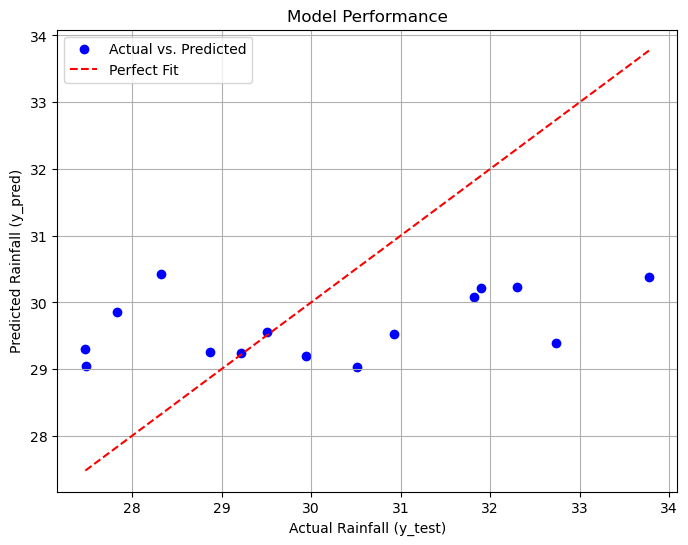

In [90]:
import matplotlib.pyplot as plt


# STEP 8: EVALUATE THE MODEL (R-SQUARED)

# We will calculate R-squared to see how good our model is.
# Formula: R2 = 1 - (SS_res / SS_tot)

# 1. Calculate SS_res (Sum of Squared Residuals)
# This is the sum of (actual - predicted)^2
residuals = y_test - y_pred
ss_res = np.sum(residuals**2)

# 2. Calculate SS_tot (Total Sum of Squares)
# This is the sum of (actual - mean_of_actual)^2
y_test_mean = np.mean(y_test)
ss_tot = np.sum((y_test - y_test_mean)**2)

# 3. Calculate R-squared
r2_score = 1 - (ss_res / ss_tot)

print(f"R-Squared (R2) Score: {r2_score}")



# A good model would have points close to the red line.
# A bad model will have points scattered everywhere.

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.xlabel("Actual Rainfall (y_test)")
plt.ylabel("Predicted Rainfall (y_pred)")
plt.title("Model Performance")
plt.legend()
plt.grid(True)
plt.show()


## STEP 8: EVALUATE THE MODEL

 We will calculate the R-Squared (R2) score to see how well our
 model performed. We will calculate this using numpy.
 R2 Formula: R2 = 1 - (SS_res / SS_tot)

 SS_res (Sum of Squared Residuals):
 This is the sum of the squared differences between the *actual* rainfall (y_test) and our *predicted* rainfall (y_pred). It measures our model's total error.

 SS_tot (Total Sum of Squares):
 This is the sum of the squared differences between the *actual* rainfall (y_test) and the *mean* of all actual rainfall. It measures the error we wouldget if we just guessed the average rainfall every single time.

 A positive R2 score means our model is better than just guessing the average.